# 2.2.1 Indicator: Mean Sea Surface Temperature - Projection

Creates plots and maps for mean sea surface temperature (tos) from 2015 onwards with projection from CMIP6

Brief introduction of CMIP6 can be found here https://www.wcrp-climate.org/wgcm-cmip/cmip-video
## Requirements
Run corresponding bash download scripts for CMIP6 tos data download and tos_palau.ipynb for tos data processing

TODO: Update directory structure and file locations for this notebook

In [1]:
import requests
import re
import urllib 
import os
import xarray as xr

from shapely.geometry import Point
import geopandas as gpd
import numpy as np

from scipy.interpolate import griddata


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [33]:
def palau_eez(df):
    df_eez = gpd.read_file('./palauEEZ.geojson')
    eez = df_eez['geometry'].values[0]
    in_palau = []
    longlat = df[['longitude','latitude']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['longitude', 'latitude']].apply(tuple, axis=1).isin(in_palau)]

In [2]:
def filter_palau(df):
    filtered = df[(df["latitude"]>= 1.25)&
                                (df["latitude"]<=13.00)&(df["longitude"]<=139.00)&
                                (df["longitude"]>=128)]
    return filtered

In [3]:
minlat = -35.0
maxlat = 35.0
minlon = 125.0
maxlon = 360.0-115.0
# date_static = '1986-01-15'
date_static = '1986-01-01'
date_static_t = 'Jan 1986'

In [4]:
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

In [5]:
# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

In [8]:
import pandas as pd
import datetime

In [10]:
import os

In [7]:
shapefile180 = '../../../Misc - Tools/shapefiles/Pacific_Island_EEZ_shifted.shp'
shapefile360 = '../../../Misc - Tools/shapefiles/Pacific_Island_EEZ.shp'

shpf180 = gpd.read_file(shapefile180)
shpf180 = shpf180.loc[:,['COUNTRYNAM','geometry']]
shpf360 = gpd.read_file(shapefile360)
shpf360['COUNTRYNAM'] = shpf180['COUNTRYNAM']
shpf360 = shpf360.loc[:,['COUNTRYNAM','geometry']]

In [9]:
def convert_to_datetime(dt):
    dt_datetime = datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    return dt_datetime

In [11]:
ssp126_list = []
folder = "/Volumes/PACIOOS2/PACIOOSFolder/Misc Files/CMIP6D/historical.ssp119.ssp126.ssp245.ssp370.ssp585/"
for x in os.listdir(folder):
    if "tos_Omon_HadGEM3-GC31-MM_ssp126_r1i1p1f3_gn_" in x:
        ssp126_list.append(xr.open_dataset(folder + x, decode_times=True))

In [12]:
def filter_pccm(df):
    filtered = df[(df["latitude"]>= -35)&
                                (df["latitude"]<=35)&(df["longitude"]<=360-115)&
                                (df["longitude"]>=125)]
    return filtered

In [13]:
ssp126_dfs = []
for x in ssp126_list:
    df = x.tos.to_dataframe()
    df = filter_pccm(df)
    ssp126_dfs.append(df.dropna(subset=['tos']))

In [14]:
master_ssp126 = pd.concat(ssp126_dfs)

In [37]:
master_ssp126.to_pickle('master_ssp126_pacific.pkl')

In [15]:
master_ssp126.reset_index(inplace = True)

In [16]:
master_ssp126

,time,j,i,latitude,longitude,tos
0,2015-01-16 00:00:00,534,208,-34.873112,125.000000,18.783590
1,2015-01-16 00:00:00,534,209,-34.873112,125.250000,18.650387
2,2015-01-16 00:00:00,534,210,-34.873112,125.500000,18.584827
3,2015-01-16 00:00:00,534,211,-34.873112,125.750000,18.624819
4,2015-01-16 00:00:00,534,212,-34.873112,126.000000,18.676559
...,...,...,...,...,...,...
57218203,2100-12-16 00:00:00,834,233,34.954494,131.167892,19.696043
57218204,2100-12-16 00:00:00,834,234,34.958458,131.418045,19.457813
57218205,2100-12-16 00:00:00,834,235,34.962414,131.668213,19.885937
57218206,2100-12-16 00:00:00,834,236,34.966354,131.918381,19.958033


In [17]:
master_ssp126['datetime'] = master_ssp126['time'].apply(convert_to_datetime)

In [18]:
import pandas as pd
import numpy as np


# Group by latitude and longitude
grouped_master = master_ssp126.groupby(['latitude', 'longitude'])

# Function to calculate trend per coordinate
def calculate_trend(group):
    # Convert datetime to numeric values (timestamps)
    time_numeric = (group['datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    # Extract sst values from the group
    sst = group['tos'].values
    
    # Perform polynomial fit
    poly_coeffs = np.polyfit(time_numeric, sst, deg=1)  # Use degree=1 for linear trend
    
    # Extract the coefficient representing the trend (slope)
    trend_coeff = poly_coeffs[0]
    
    # Convert trend from units per second to units per decade
    trend_deg_per_decade = trend_coeff * 10 * 365.25 * 24 * 60 * 60  # As there are 10 years in a decade
    
    return trend_deg_per_decade

# Apply the function to each group and store the results in a DataFrame
master_ssp126_trend_results = grouped_master.apply(calculate_trend)
master_ssp126_trend_df = master_ssp126_trend_results.reset_index(name='trend')


In [19]:
master_ssp126_trend_df['long_test'] = master_ssp126_trend_df['longitude'] - 180

In [20]:
master_ssp126_trend_df

,latitude,longitude,trend,long_test
0,-34.873112,125.000000,0.190166,-55.000000
1,-34.873112,125.250000,0.193478,-54.750000
2,-34.873112,125.500000,0.197266,-54.500000
3,-34.873112,125.750000,0.197996,-54.250000
4,-34.873112,126.000000,0.196891,-54.000000
...,...,...,...,...
55439,34.988285,148.193222,0.162024,-31.806778
55440,34.990963,148.443680,0.169997,-31.556320
55441,34.993618,148.694122,0.173878,-31.305878
55442,34.996246,148.944580,0.175729,-31.055420


/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_60922/3076916559.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',


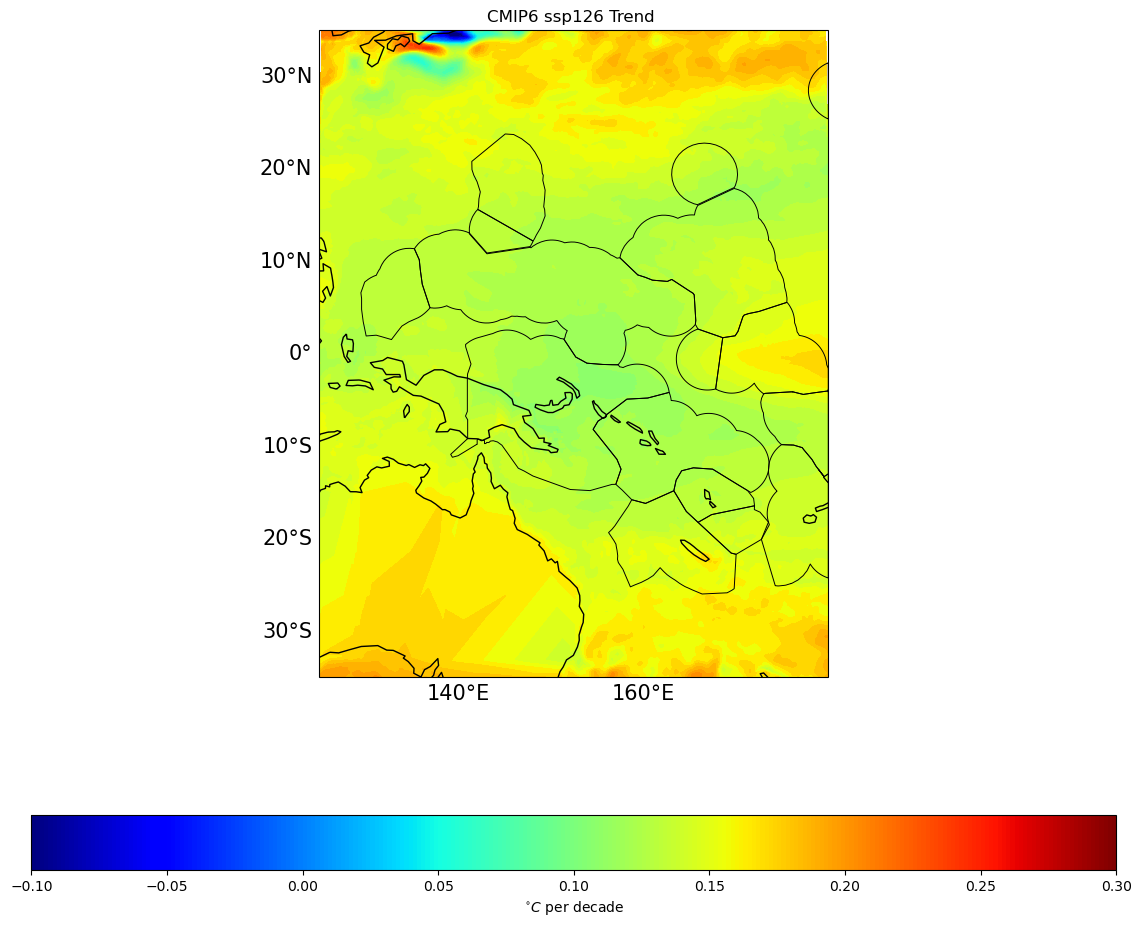

In [24]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = -0.1, 0.3
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))


x_orig = np.asarray(master_ssp126_trend_df.long_test.tolist())
y_orig = np.asarray(master_ssp126_trend_df.latitude.tolist())
z_orig = np.asarray(master_ssp126_trend_df.trend.tolist())


x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')


ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)


    
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)
    
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('CMIP6 ssp126 Trend ')
plt.savefig('projection-sst-ssp126-west-pacific-map.png', format='png',dpi=300,facecolor='white')

In [22]:
ssp126_palau = filter_palau(master_ssp126_trend_df)

In [23]:
ssp126_palau

,latitude,longitude,trend,long_test
24024,1.499829,128.25,0.125242,-51.75
24025,1.499829,128.75,0.125290,-51.25
24026,1.499829,129.00,0.124309,-51.00
24027,1.499829,129.25,0.123812,-50.75
24028,1.499829,129.50,0.123532,-50.50
...,...,...,...,...
34071,12.889874,138.00,0.135699,-42.00
34072,12.889874,138.25,0.135331,-41.75
34073,12.889874,138.50,0.134746,-41.50
34074,12.889874,138.75,0.134445,-41.25


/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_60922/2311975232.py:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',


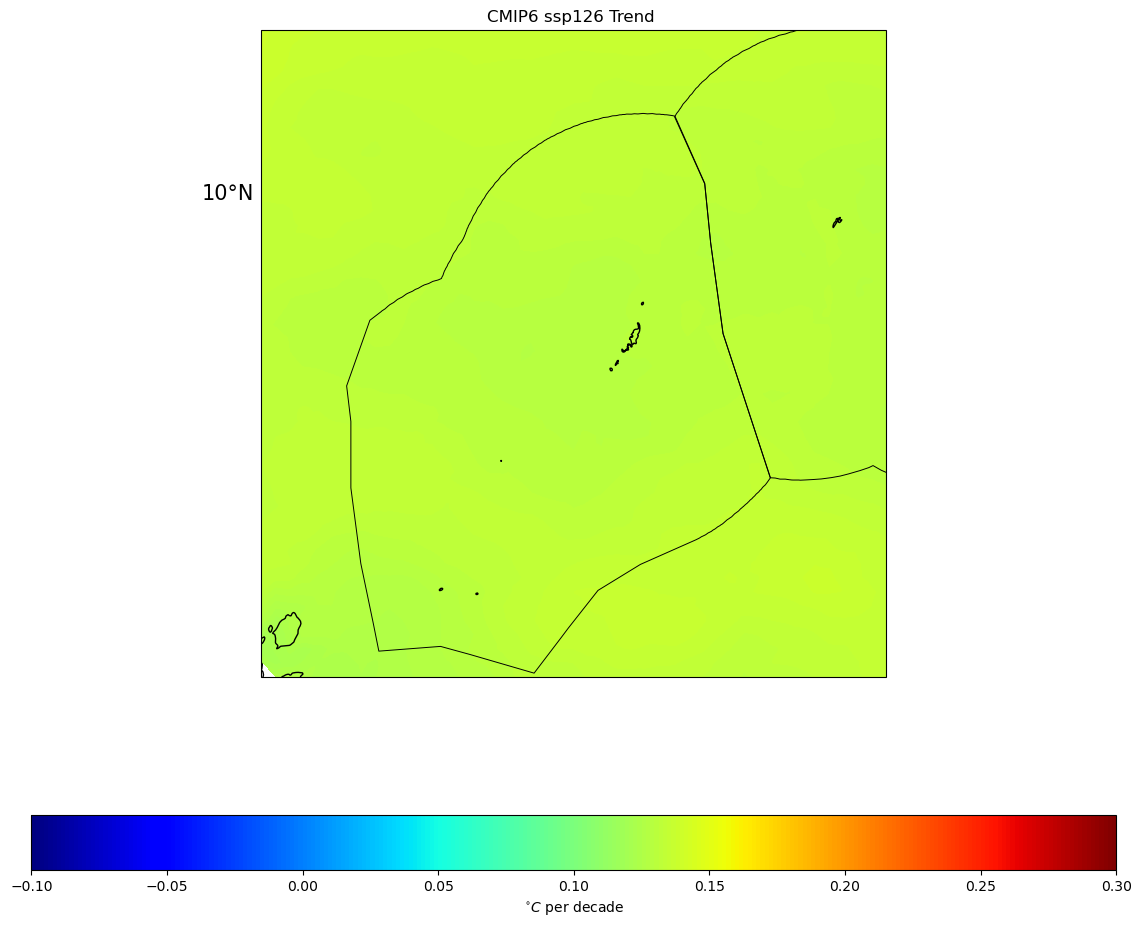

In [25]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = -0.1, 0.3
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))


x_orig = np.asarray(ssp126_palau.long_test.tolist())
y_orig = np.asarray(ssp126_palau.latitude.tolist())
z_orig = np.asarray(ssp126_palau.trend.tolist())


x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')


ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)


    
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)
    

plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('CMIP6 ssp126 Trend ')
plt.savefig('projection-sst-ssp126-palau-map.png', format='png',dpi=300,facecolor='white')

/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pccm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_60922/409495358.py:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',


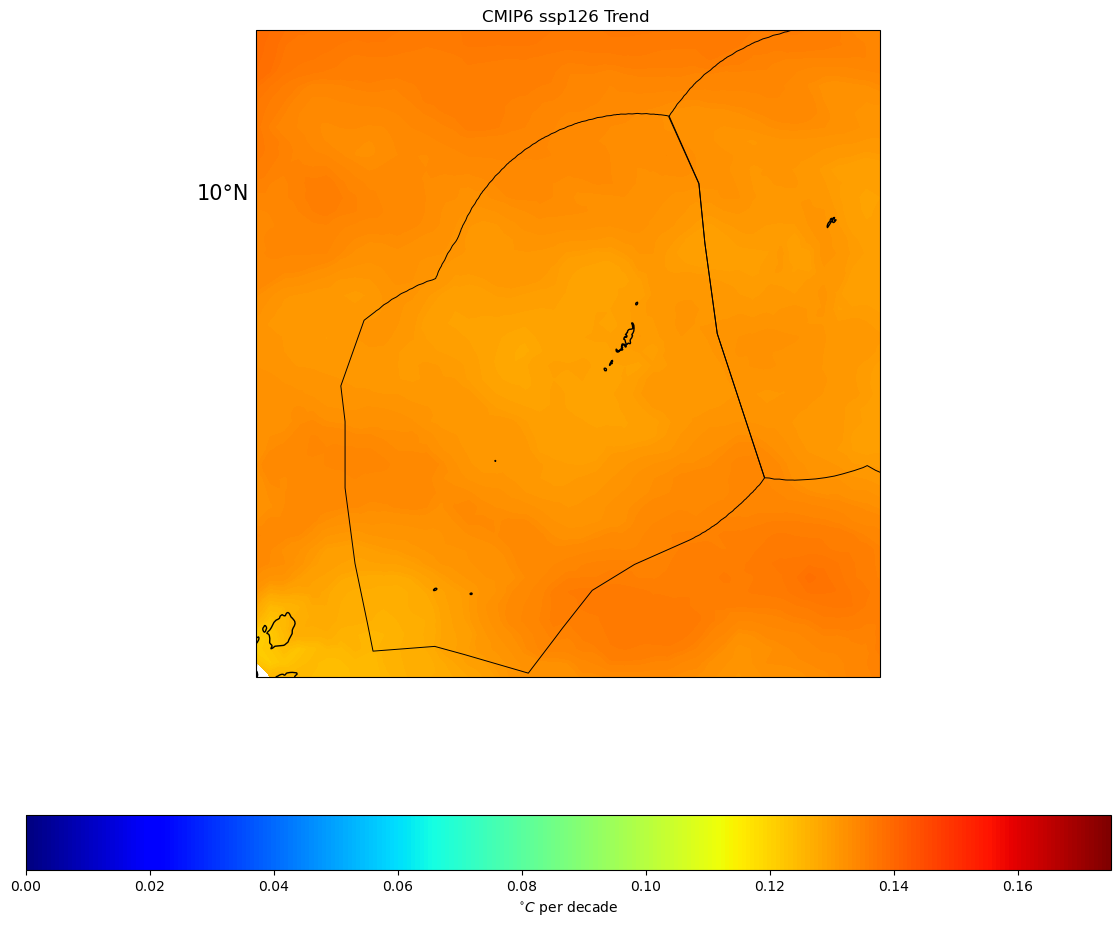

In [30]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = 0.0, 0.175
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.10, vmax=vmax)

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))


x_orig = np.asarray(ssp126_palau.long_test.tolist())
y_orig = np.asarray(ssp126_palau.latitude.tolist())
z_orig = np.asarray(ssp126_palau.trend.tolist())


x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')


ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)


    
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)
    

plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('CMIP6 ssp126 Trend ')
plt.savefig('projection-sst-ssp126-palau-map-adjusted.png', format='png',dpi=300,facecolor='white')

In [36]:
ssp126_eez = palau_eez(filter_palau(master_ssp126))

In [42]:
ssp126_eez_avg = ssp126_eez.groupby('datetime')['tos'].mean()

In [47]:
ssp126_eez_avg_dict = ssp126_eez_avg.to_dict()

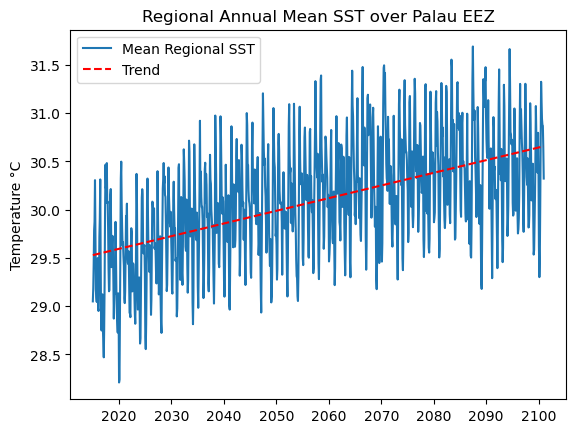

In [56]:
fig, ax = plt.subplots()
ax.plot(ssp126_eez_avg_dict.keys(),ssp126_eez_avg_dict.values(), label = "Mean Regional SST")
# ax.set_ylim(-10, 50)
# Fit trend line

x_temp = np.arange(len(ssp126_eez_avg_dict))
slope, intercept = np.polyfit(x_temp, list(ssp126_eez_avg_dict.values()), 1)
ax.plot(ssp126_eez_avg_dict.keys(), np.polyval([slope, intercept], x_temp), '--', color='red', label='Trend')

ax.legend()
plt.ylabel('Temperature °C')
plt.title("Regional Annual Mean SST over Palau EEZ")
plt.savefig('projection-sst-ssp126-palau-plot.png', format='png',dpi=300,facecolor='white')
plt.show()